In [2]:
import numpy as np
import pandas as pd
import copy as cp
import matplotlib.pyplot as plt

In [95]:
# Set as 0 if using results from no control simulation
# Set as 1 if using results from control, flow/TSS load simulation
# Set as 2 if using results from control, flow simulation
# Set as 3 if using results from control, TSS load simulation
save = 3

stormNo = '3'

# Load storm event data (LBC results, for sewer subsection only)
# WRRF flow is in units of cubic feet/sec
# WRRF TSS load is in units of lb/sec
# WRRF TSS concentration is in units of mg/L
storm_nocontrol = np.load('../data/storm'+stormNo+'.npy', allow_pickle=True)

if save == 0:
    storm = cp.deepcopy(storm_nocontrol)
    file_c = 'nc'
elif save == 1:
    storm_control = np.load('../data/storm'+stormNo+'_control_both.npy', allow_pickle=True)
    storm = cp.deepcopy(storm_control)
    file_c = 'c_both'
elif save == 2:
    storm_control = np.load('../data/storm'+stormNo+'_control_flow.npy', allow_pickle=True)
    storm = cp.deepcopy(storm_control)
    file_c = 'c_flow'
elif save == 3:
    storm_control = np.load('../data/storm'+stormNo+'_control_TSS.npy', allow_pickle=True)
    storm = cp.deepcopy(storm_control)
    file_c = 'c_TSS'

# File name for influent tsv
w_influentTSV = 'C:/Users/Sara/Desktop/sewerWRRF/data/storm'+stormNo+'_'+file_c+'_influent.tsv'

In [96]:
# Check storm event data contents
storm

array({'time': array([[28.],
       [28.],
       [28.],
       ...,
       [37.],
       [37.],
       [37.]], dtype=float16), 'WRRF_flow': array([[199.63414],
       [199.63525],
       [199.63641],
       ...,
       [198.72772],
       [198.724  ],
       [198.72041]], dtype=float32), 'WRRF_TSSLoad': array([[1.9765158],
       [1.9765999],
       [1.9766845],
       ...,
       [1.9710642],
       [1.9710968],
       [1.971131 ]], dtype=float32), 'WRRF_TSSConc': array([[158.54905228],
       [158.55490593],
       [158.56077603],
       ...,
       [158.83290506],
       [158.83849563],
       [158.84411908]]), 'WRRF_flow_dry': array([198.01916504, 198.01844788, 198.01780701, ..., 198.72772217,
       198.72399902, 198.72041321]), 'WRRF_TSSLoad_dry': array([1.97024274, 1.97030628, 1.97037041, ..., 1.97106421, 1.97109675,
       1.97113097]), 'WRRF_flow_wet': array([1.61497498, 1.61680603, 1.61860657, ..., 0.        , 0.        ,
       0.        ]), 'WRRF_TSSLoad_wet': array([0.006

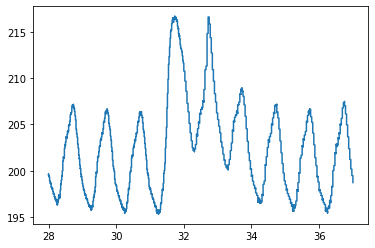

In [97]:
# Flow in sewer subsection (only)
plt.plot(storm.item().get('time'),storm.item().get('WRRF_flow'))

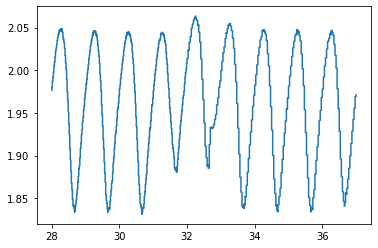

In [98]:
# TSS load in sewer subsection (only)
plt.plot(storm.item().get('time'),storm.item().get('WRRF_TSSLoad'))

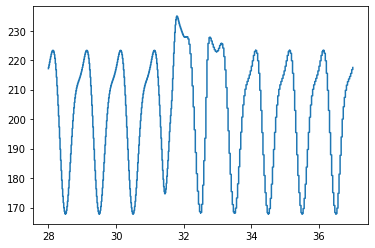

In [99]:
# Flow in sewer subsection (only)
# NO CONTROL results shown here
plt.plot(storm_nocontrol.item().get('time'),storm_nocontrol.item().get('WRRF_flow'))

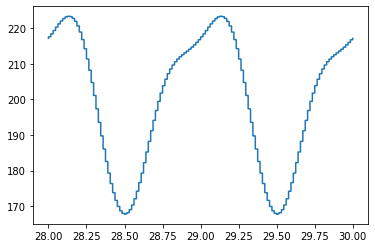

In [100]:
# Plot section that is dry-weather only
# Will average over this section to get dry-weather average value
# This is done for the NO CONTROL results shown above
dw_start = 0*24*60*60/10
dw_end = 2*24*60*60/10 #-1
plt.plot(storm_nocontrol.item().get('time')[int(dw_start):int(dw_end)],storm_nocontrol.item().get('WRRF_flow')[int(dw_start):int(dw_end)])

seweroutflow = np.mean(storm_nocontrol.item().get('WRRF_flow')[int(dw_start):int(dw_end)])

In [101]:
# Using ./data/flowPrecip.xlsx average dry-weather WRRF inflow is about 520.30 Mgal/d (1.9695 Mm3/d)
### OLD Average WRRF inflow is 2,788,860 m3/d
# Converting m3/d to cubic feet/sec ...
WRRFinflow = 1969500 * 35.3147 / 86400

In [102]:
# Ratio to scale from sewer subsection to GLWA WRRF influent
# Ratio should be about 4.02197
scale_ratio = WRRFinflow/seweroutflow
scale_ratio

4.021934198773301

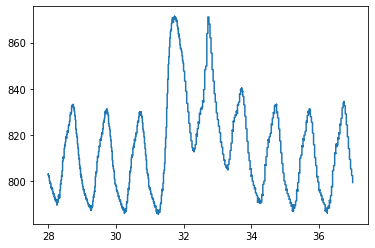

In [103]:
# Flow for GLWA WRRF influent
plt.plot(storm.item().get('time'),scale_ratio*storm.item().get('WRRF_flow'))

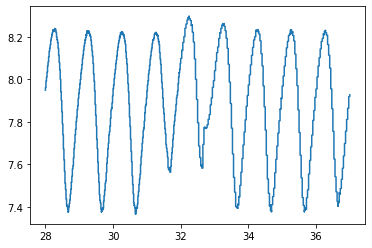

In [104]:
# TSS load for GLWA WRRF influent
plt.plot(storm.item().get('time'),scale_ratio*storm.item().get('WRRF_TSSLoad'))

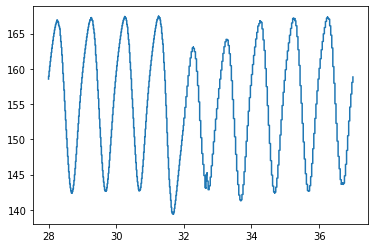

In [105]:
# TSS concentration for GLWA WRRF influent (same as that for sewer subsection since concentration)
plt.plot(storm.item().get('time'),storm.item().get('WRRF_TSSConc'))

In [106]:
# Using GLWA WRRF model, ...
# influent TP is 2.2 mg P/L, 
# fraction of PO4 in total phosphorus is 53.3%, so influent SP is 1.1726 mg P/L, 
# influent PP (particular phosphorus) is 1.0274 mg P/L

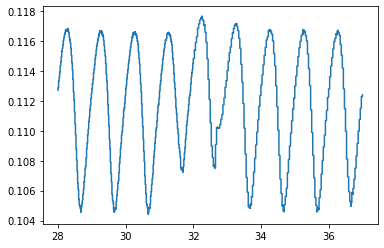

In [107]:
# For current simplification, phosphorus will only include total phosphorus without fractionation
# and will mirror TSS dynamics

# TP concentration in mg/L
WRRF_TPConc = storm.item().get('WRRF_TSSConc') / np.mean(storm.item().get('WRRF_TSSConc')) * 2.2

# TP load in lb/sec for GLWA WRRF influent
WRRF_TPLoad = np.multiply(WRRF_TPConc,scale_ratio*storm.item().get('WRRF_flow')) * 2.205 / (10**6) * 28.32

# TP load for GLWA WRRF influent
plt.plot(storm.item().get('time'),WRRF_TPLoad)

In [108]:
storm_df = pd.DataFrame(data=np.column_stack((storm.item().get('time'),
                                        scale_ratio*storm.item().get('WRRF_flow'),
                                        scale_ratio*storm.item().get('WRRF_TSSLoad'),
                                        storm.item().get('WRRF_TSSConc'),
                                        WRRF_TPLoad,
                                        WRRF_TPConc)),
                  columns=['time',
                           'WRRF_flow',
                           'WRRF_TSSLoad',
                           'WRRF_TSSConc',
                           'WRRF_TPLoad',
                           'WRRF_TPConc'])
storm_df

,time,WRRF_flow,WRRF_TSSLoad,WRRF_TSSConc,WRRF_TPLoad,WRRF_TPConc
0,28.0,802.915344,7.949416,158.549052,0.112709,2.247959
1,28.0,802.919800,7.949755,158.554906,0.112714,2.248042
2,28.0,802.924500,7.950095,158.560776,0.112719,2.248125
3,28.0,802.929199,7.950435,158.566646,0.112724,2.248209
4,28.0,802.934082,7.950777,158.572500,0.112729,2.248292
...,...,...,...,...,...,...
77755,37.0,799.301758,7.927247,158.821675,0.112395,2.251825
77756,37.0,799.285461,7.927365,158.827282,0.112397,2.251904
77757,37.0,799.269775,7.927490,158.832905,0.112398,2.251984
77758,37.0,799.254822,7.927621,158.838496,0.112400,2.252063


In [109]:
with open(w_influentTSV,'w') as write_tsv:
    write_tsv.write(storm_df.to_csv(sep='\t', index=False))